In [62]:
import logging
import re
from typing import Literal, Annotated

import numpy as np
import numpy.typing as npt
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path

from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity

logging.basicConfig(format='%(asctime)s [%(levelname)s] %(name)s: %(message)s', level=logging.DEBUG)
logger = logging.getLogger('base')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logger.setLevel(logging.DEBUG)

pd.options.display.max_columns = 650
pd.options.display.max_rows = 20

In [63]:
df = pd.read_csv('../data/results/results.csv')
print(df.shape)
print(list(df.columns))
df.head()

(453813, 40)
['dataset', 'sim-rep', 'sim_key', 'batch_i', 'n_total', 'n_seen', 'n_unseen', 'n_incl', 'n_incl_seen', 'n_incl_batch', 'n_records_batch', 'method', 'safe_to_stop', 'method-hash', 'method-KEY', 'method-safe_to_stop', 'method-score', 'method-recall_target', 'method-bias', 'method-confidence_level', 'method-window_size', 'method-polyorder', 'method-threshold_ratio', 'method-threshold_peak', 'method-slope_ratio', 'method-smoothing', 'method-expected_includes', 'method-expected_remaining', 'method-predicted_recall', 'method-num_to_stop', 'method-fraction', 'method-n_windows', 'method-curve_estimate', 'method-batch_size', 'method-threshold', 'method-current_precision', 'method-alpha', 'method-constant', 'method-num_reviewed', 'method-num_relevant_reviewed']


,dataset,sim-rep,sim_key,batch_i,n_total,n_seen,n_unseen,n_incl,n_incl_seen,n_incl_batch,n_records_batch,method,safe_to_stop,method-hash,method-KEY,method-safe_to_stop,method-score,method-recall_target,method-bias,method-confidence_level,method-window_size,method-polyorder,method-threshold_ratio,method-threshold_peak,method-slope_ratio,method-smoothing,method-expected_includes,method-expected_remaining,method-predicted_recall,method-num_to_stop,method-fraction,method-n_windows,method-curve_estimate,method-batch_size,method-threshold,method-current_precision,method-alpha,method-constant,method-num_reviewed,method-num_relevant_reviewed
0,generic-paired-ris-NICE CG170,3,generic-paired-ris-NICE CG170-0-500-3-best,0,1240,15,1225,38,0,0,15,BUSCAR,False,BUSCAR-d0cb3885da47cdd7116e42a25e1ffb507e22c715,BUSCAR,False,0.987903,0.8,1.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,generic-paired-ris-NICE CG170,3,generic-paired-ris-NICE CG170-0-500-3-best,0,1240,15,1225,38,0,0,15,BUSCAR,False,BUSCAR-acbe70bfb087950c3c4f7c4dd935df2accca0966,BUSCAR,False,0.987903,0.8,2.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,generic-paired-ris-NICE CG170,3,generic-paired-ris-NICE CG170-0-500-3-best,0,1240,15,1225,38,0,0,15,BUSCAR,False,BUSCAR-65b0784c5421872b769f7899dfeeb10ef11bc59a,BUSCAR,False,0.987903,0.8,5.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,generic-paired-ris-NICE CG170,3,generic-paired-ris-NICE CG170-0-500-3-best,0,1240,15,1225,38,0,0,15,BUSCAR,False,BUSCAR-0cb824deffd1fac67da3a1cde0981477077be802,BUSCAR,False,0.987903,0.8,10.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,generic-paired-ris-NICE CG170,3,generic-paired-ris-NICE CG170-0-500-3-best,0,1240,15,1225,38,0,0,15,BUSCAR,False,BUSCAR-bb5e08fb12b0f17b6a29d0c5e85c4b5c64695b14,BUSCAR,False,0.987903,0.9,1.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
for (hash_ranker, hash_method, repeat), sub_df in df.groupby(['sim_key', 'method-hash', 'sim-rep']):
    simulation = sub_df.sort_values(by=['batch_i'])
    info = simulation.iloc[0]
    logger.info(f'Dataset "{info['dataset']}" stopped by "{info['method']}" (repeat {repeat} via {hash_method} / {hash_ranker})')
    for _, step in simulation.iterrows():
        recall = step['n_incl_seen'] / step['n_incl']

        logger.info(f'Batch {step['batch_i']}: {step['n_seen']:,}/{step['n_total']:,} seen; '
              f'{step['n_incl_seen']:,}/{step['n_incl']:,} includes found; '
              f'recall={recall:.2%} | safe to stop: {step['safe_to_stop']}')

    logger.info('---')
    break

2025-06-11 20:18:10,663 [INFO] base: Dataset "clef-CD005139" stopped by "ALISON" (repeat 2 via ALISON-417e55e2a26d7f24cad8370396678f36024acb8f / clef-CD005139-0-500-2-best)
2025-06-11 20:18:10,665 [INFO] base: Batch 0: 15/4,564 seen; 0/105 includes found; recall=0.00% | safe to stop: False
2025-06-11 20:18:10,667 [INFO] base: Batch 1: 30/4,564 seen; 2/105 includes found; recall=1.90% | safe to stop: False
2025-06-11 20:18:10,668 [INFO] base: Batch 2: 45/4,564 seen; 2/105 includes found; recall=1.90% | safe to stop: False
2025-06-11 20:18:10,669 [INFO] base: Batch 3: 60/4,564 seen; 2/105 includes found; recall=1.90% | safe to stop: False
2025-06-11 20:18:10,670 [INFO] base: Batch 4: 75/4,564 seen; 2/105 includes found; recall=1.90% | safe to stop: False
2025-06-11 20:18:10,672 [INFO] base: Batch 5: 90/4,564 seen; 2/105 includes found; recall=1.90% | safe to stop: False
2025-06-11 20:18:10,673 [INFO] base: Batch 6: 105/4,564 seen; 3/105 includes found; recall=2.86% | safe to stop: False


In [65]:
results = []
for (hash_ranker, hash_method, repeat), sub_df in df.groupby(['sim_key', 'method-hash', 'sim-rep']):
    simulation = sub_df.sort_values(by=['batch_i'])
    simulation = simulation.where(simulation['dataset'].notna())
    #info = simulation.iloc[0]
    #logger.info(f'Dataset "{info['dataset']}" stopped by "{info['method']}" (repeat {repeat} via {hash_method} / {hash_ranker})')
    stop_rows = simulation[simulation['safe_to_stop']]
    stop_row = stop_rows.iloc[0] if  len(stop_rows) > 0 else simulation.iloc[-1]
    
    results.append({
        'recall': stop_row['n_incl_seen'] / stop_row['n_incl'],
        'work_saved': stop_row['n_unseen'] / stop_row['n_total'],
        'incl_missed': (stop_row['n_incl'] - stop_row['n_incl_seen']) / stop_row['n_incl'],
        **stop_row.to_dict()
    })

In [66]:
df_res = pd.DataFrame(results)

<Axes: >

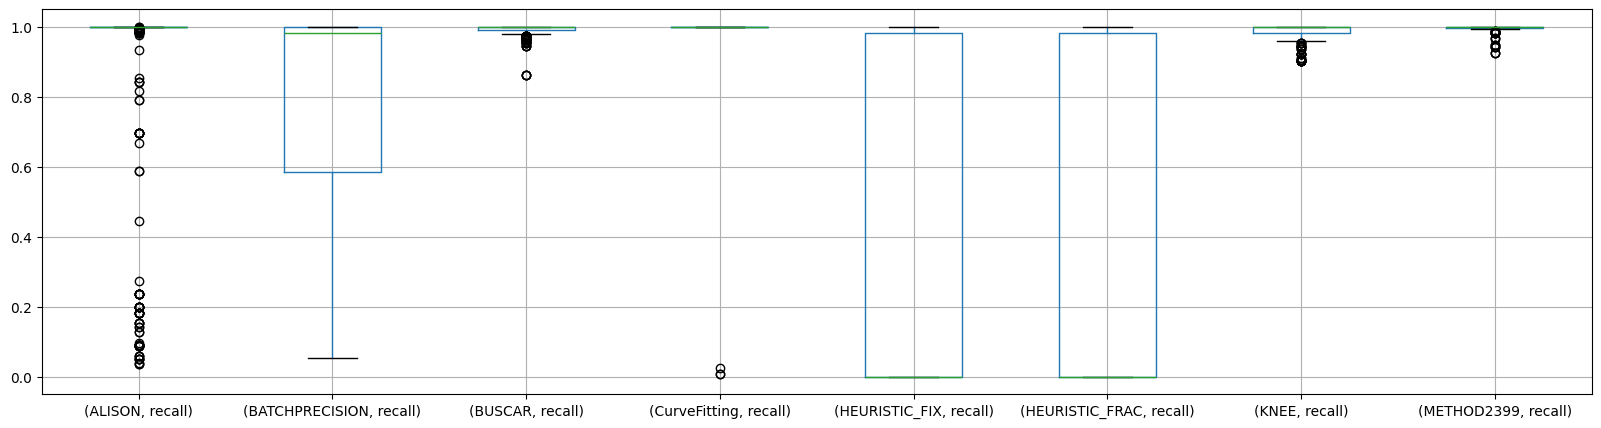

In [73]:
df_res.groupby('method').boxplot(subplots=False, column='recall', figsize=(20, 5))

In [87]:
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]
ax#(rect_scatter)

<Axes: title={'center': 'METHOD2399'}, xlabel='work_saved', ylabel='recall'>

In [120]:
ax_histx.hist(df_res[df_res['method'] == meth]['work_saved'], bins=bins, density=True)

(array([12.        ,  2.28571429,  0.38095238,  0.19047619,  0.57142857,
         0.        ,  1.14285714,  0.        ,  0.57142857,  1.14285714,
         0.        ,  0.57142857,  0.        ,  0.57142857,  0.        ,
         0.57142857,  0.        ,  0.        ,  0.        ,  0.        ]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

In [121]:
ax_histx.hist(df_res[df_res['method'] == meth]['work_saved'], bins=bins, density=False)

(array([63., 12.,  2.,  1.,  3.,  0.,  6.,  0.,  3.,  6.,  0.,  3.,  0.,
         3.,  0.,  3.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

In [123]:
np.histogram(df_res[df_res['method'] == meth]['work_saved'], bins=bins)

(array([63, 12,  2,  1,  3,  0,  6,  0,  3,  6,  0,  3,  0,  3,  0,  3,  0,
         0,  0,  0]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]))

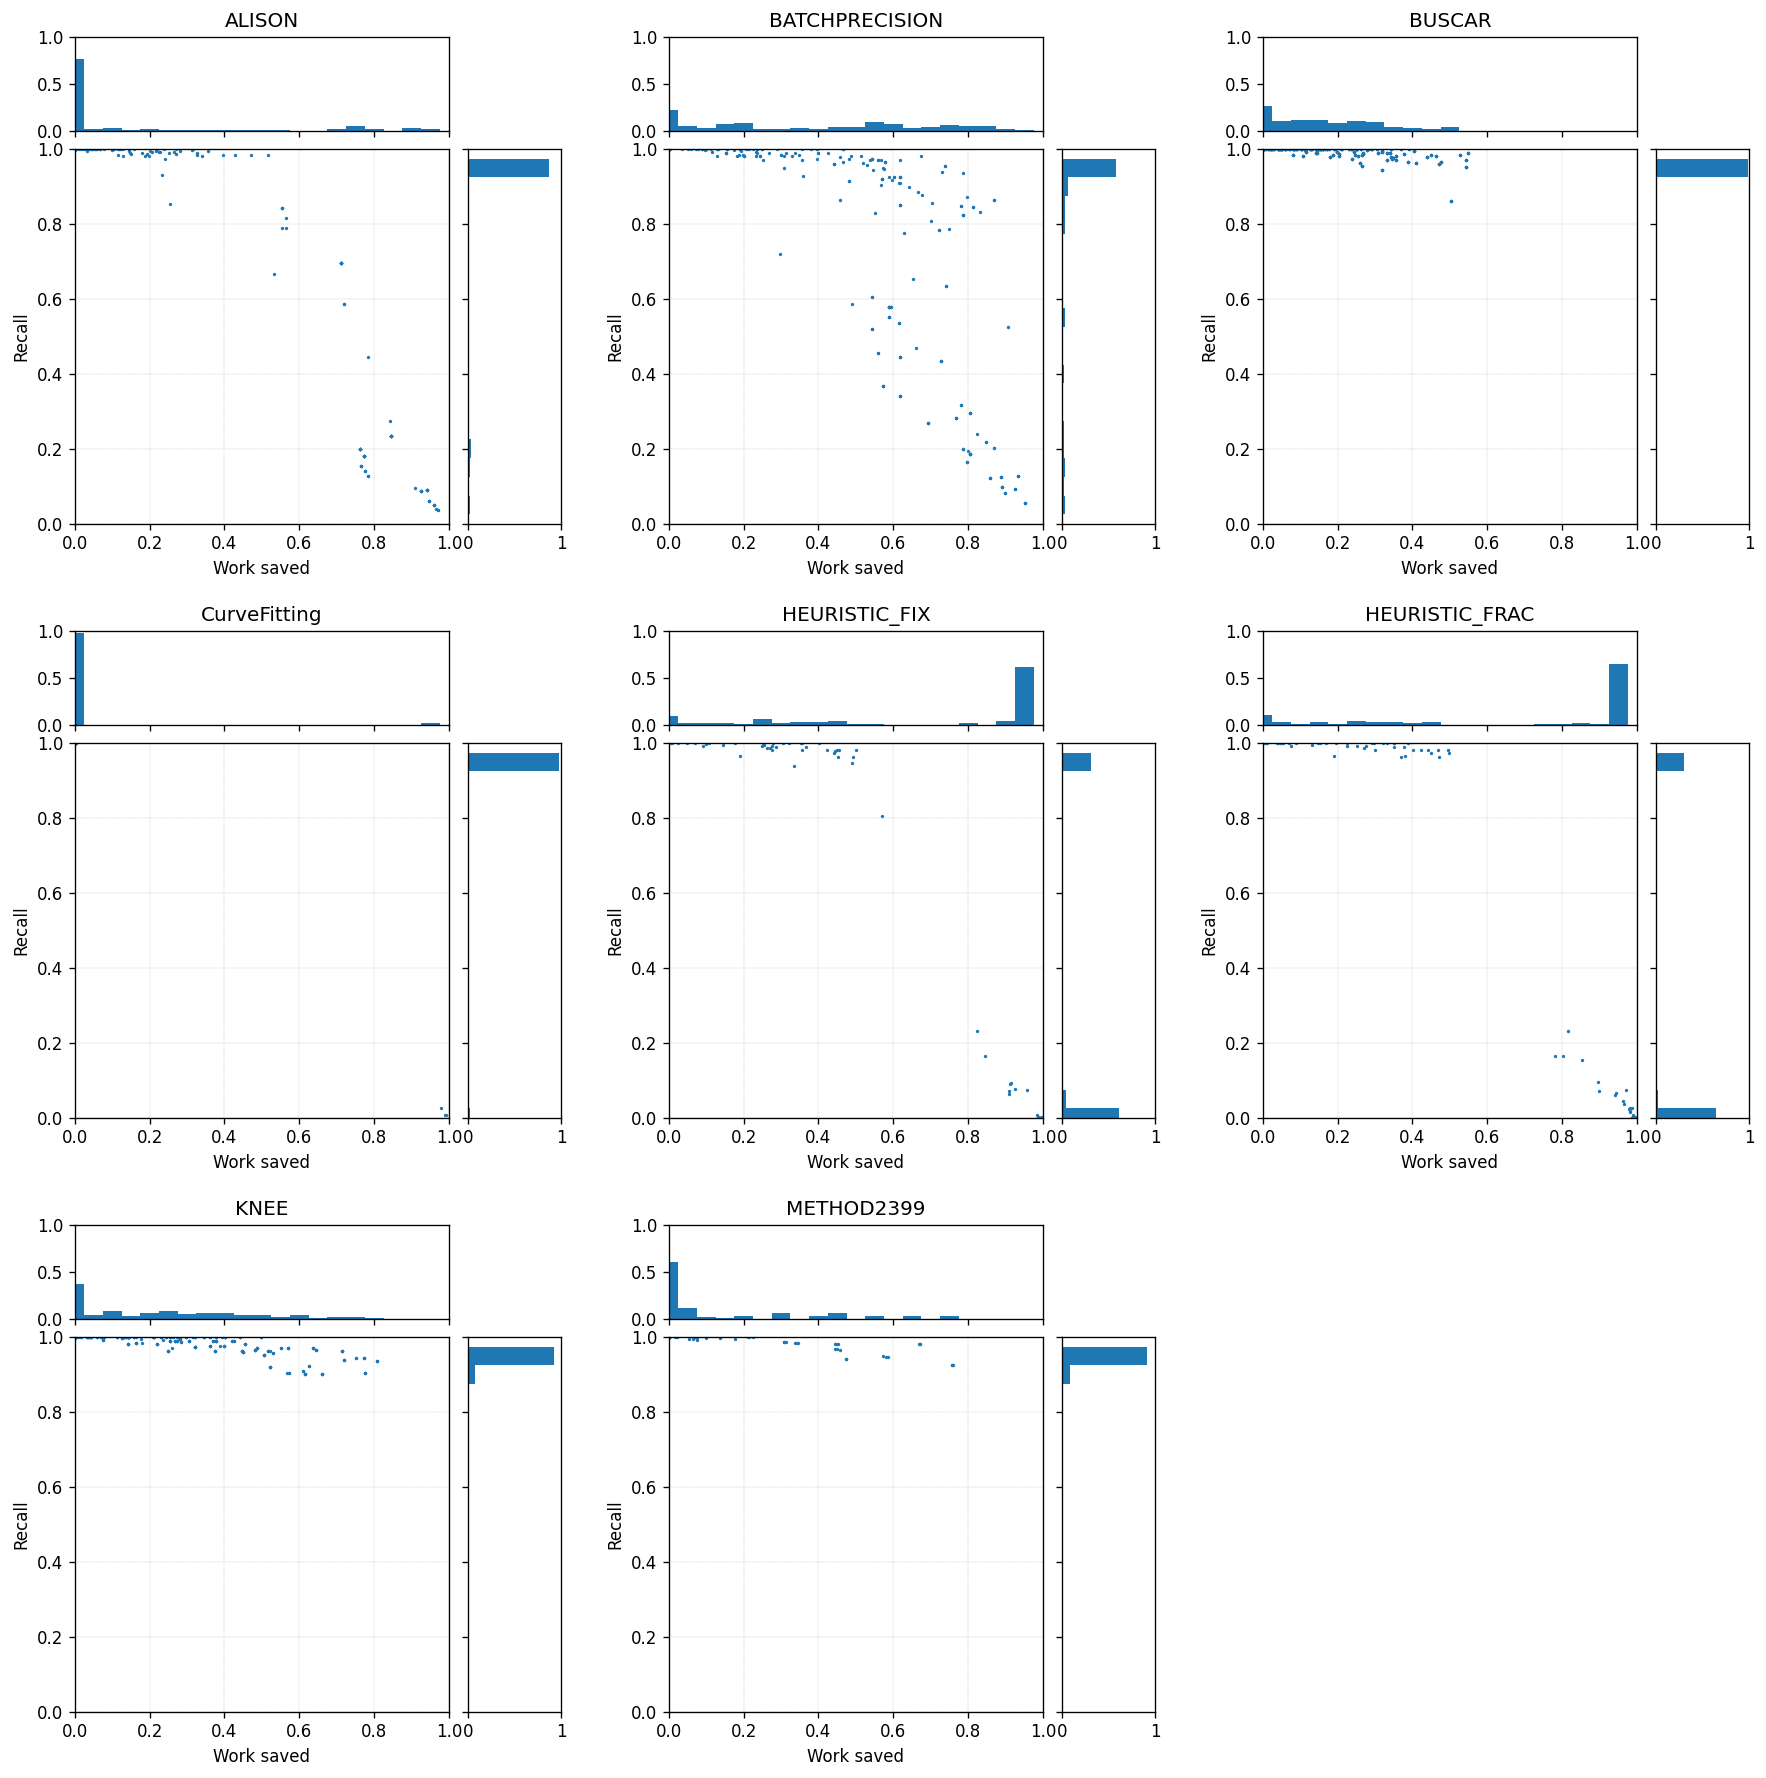

In [156]:
hists_y = {}
hists_x = {}

n_methods = len(df_res['method'].unique())
n_cols = 3
n_rows = (n_methods // n_cols)+1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows), dpi=120)
for mi, meth in enumerate(df_res['method'].unique()):
    ax = axes[int(mi/n_cols)][mi%n_cols]

    ax.set_aspect('equal')
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.25])
    ax_histy = ax.inset_axes([1.05, 0, 0.25, 1])

    df_res[df_res['method'] == meth].plot.scatter(x='work_saved', y='recall', ax=ax, s=1)
    
    ax.set_title(meth)
    ax.set_ylabel('Recall')
    ax.set_xlabel('Work saved')
    ax.grid(lw=0.2, ls='--')
    
    bins = 20
    binwidth = 1 / bins
    bins = np.arange(0, 1 + binwidth, binwidth)
    histx, _ = np.histogram(df_res[df_res['method'] == meth]['work_saved'], bins=bins)
    histy, _ = np.histogram(df_res[df_res['method'] == meth]['recall'], bins=bins)
    hists_x[meth] = histx
    hists_y[meth] = histy
    
    ax_histx.bar(bins[:-1], height=histx / histx.sum(), width=binwidth)
    ax_histy.barh(y=bins[:-1], width=histy / histy.sum(), height=binwidth)
    
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax.axes.xaxis.set_visible(True)
    ax.axes.yaxis.set_visible(True)
    
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    ax_histx.set_xlim(0,1)
    ax_histx.set_ylim(0,1)
    ax_histy.set_xlim(0,1)
    ax_histy.set_ylim(0,1)

fig.delaxes(axes[2][2])
    
fig.tight_layout()
#fig.show()

In [151]:
pd.DataFrame(hists_y | {'Recall': bins[:-1]}).style.background_gradient(cmap='Blues', axis=0)

,ALISON,BATCHPRECISION,BUSCAR,CurveFitting,HEURISTIC_FIX,HEURISTIC_FRAC,KNEE,METHOD2399,Recall
0,7,0,0,3,85,113,0,0,0.000000
1,15,10,0,0,6,5,0,0,0.050000
2,4,9,0,0,0,0,0,0,0.100000
3,12,10,0,0,1,3,0,0,0.150000
4,17,8,0,0,1,1,0,0,0.200000
5,1,9,0,0,0,0,0,0,0.250000
6,0,5,0,0,0,0,0,0,0.300000
7,0,3,0,0,0,0,0,0,0.350000
8,1,6,0,0,0,0,0,0,0.400000
9,0,3,0,0,0,0,0,0,0.450000


In [153]:
pd.DataFrame(hists_x | {'Work saved': bins[:-1]}).style.background_gradient(cmap='Blues', axis=0)

,ALISON,BATCHPRECISION,BUSCAR,CurveFitting,HEURISTIC_FIX,HEURISTIC_FRAC,KNEE,METHOD2399,Work saved
0,428,70,148,137,13,18,156,63,0.000000
1,12,15,60,0,2,4,17,12,0.050000
2,15,7,64,0,3,2,35,2,0.100000
3,6,21,64,0,2,4,12,1,0.150000
4,9,24,44,0,1,2,25,3,0.200000
5,6,6,56,0,8,6,32,0,0.250000
6,5,6,52,0,3,4,21,6,0.300000
7,2,9,24,0,4,5,23,0,0.350000
8,1,4,16,0,4,3,23,3,0.400000
9,1,11,12,0,5,5,18,6,0.450000


<Axes: xlabel='work_saved', ylabel='recall'>

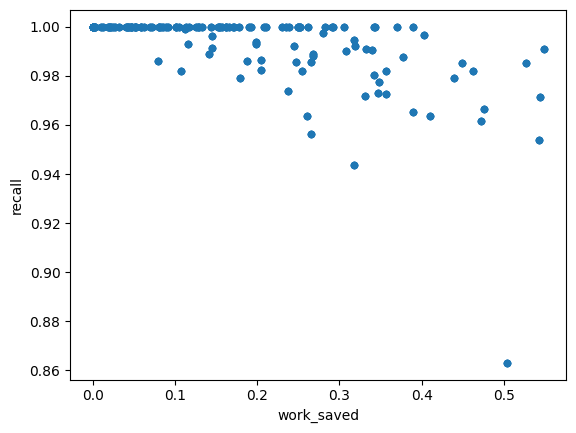

In [74]:
df_res[df_res['method'] == 'BUSCAR'].plot.scatter(x='work_saved', y='recall')

<Axes: xlabel='method-recall_target', ylabel='recall'>

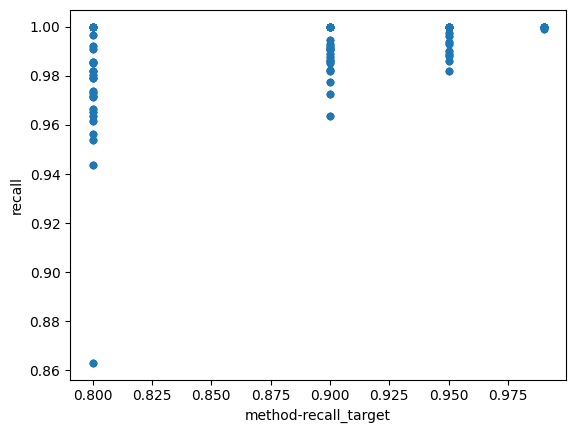

In [71]:
df_res[df_res['method'] == 'BUSCAR'].plot.scatter(x='method-recall_target', y='recall')